In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

## START

In [ ]:
train_gen=ImageDataGenerator(rescale=1/255.0,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
train_data=train_gen.flow_from_directory('/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/train', 
                                        target_size= (128, 128),
                                       class_mode = 'categorical', 
                                       batch_size = 32, 
                                       shuffle = True,
                                       subset='training')
test_data=train_gen.flow_from_directory('/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/test', 
                                        target_size= (128, 128),
                                        class_mode = 'categorical', 
                                        batch_size = 32, 
                                        shuffle = True)


Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


## Or

In [3]:
from sklearn.utils import shuffle
DATA=[]
for main_ in ['train', 'test']:
  for i,folder in enumerate(os.listdir(f'/content/drive/MyDrive/Alzheimer Datasets/A5 Classes/Alzheimers-ADNI/{main_}')):
    for image in os.listdir(f'/content/drive/MyDrive/Alzheimer Datasets/A5 Classes/Alzheimers-ADNI/{main_}/{folder}'):
      img=cv2.imread(f'/content/drive/MyDrive/Alzheimer Datasets/A5 Classes/Alzheimers-ADNI/{main_}/{folder}/{image}')
      img=cv2.resize(img,(128,128))/255.0
      DATA.append((img,i))
DATA=np.array(shuffle(DATA))

<ipython-input-3-35e9c4873570>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  DATA=np.array(shuffle(DATA))


In [5]:
Images=np.array([i for i in DATA[:,0]]).reshape((1296,128,128,3))
Labels=DATA[:,1].astype(np.float32)

In [6]:
x_train,x_test,y_train,y_test=Images[:900],Images[900:],Labels[:900],Labels[900:]
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((900, 128, 128, 3), (396, 128, 128, 3), (900,), (396,))

In [7]:
from keras.utils import to_categorical
y_train=to_categorical(y_train,5)
y_test=to_categorical(y_test,5)
y_train.shape

(900, 5)

## Compact Convolutional Vision Transformer

## Loading Data

In [8]:
positional_emb = True
conv_layers = 4
projection_dim = 128
input_shape=(128,128,3)
image_size = 128
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
num_classes=4
num_heads = 4
transformer_units = [projection_dim,projection_dim]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 30
from sklearn.utils import shuffle
from keras import layers


In [9]:
class CCTTokenizer(layers.Layer):
    def __init__(self,kernel_size=3,stride=1,padding=1,pooling_kernel_size=3,pooling_stride=2,num_conv_layers=conv_layers,
        num_output_channels=[16, 128, 32, 128],positional_emb=positional_emb,**kwargs,):
      super(CCTTokenizer, self).__init__(**kwargs)
      self.conv_model = keras.Sequential()
      for i in range(num_conv_layers):
          self.conv_model.add(layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                ))
          self.conv_model.add(layers.ZeroPadding2D(padding))
          self.conv_model.add(layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same"))
      self.positional_emb = positional_emb
    def call(self, images):
        outputs = self.conv_model(images)
        reshaped = tf.reshape(
            outputs,  (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]))
        return reshaped
    def positional_embedding(self, image_size):
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

In [10]:
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop
    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (tf.shape(x).shape[0] - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

data_augmentation = keras.Sequential(
    [layers.RandomCrop(image_size, image_size),layers.RandomFlip("horizontal")],
    name="data_augmentation"
                    )

In [11]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) 
        return encoded

Image size: 128 X 128
Patch size: 8 X 8
Patches per image: 256
Elements per patch: 192


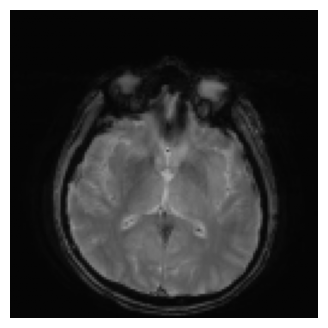

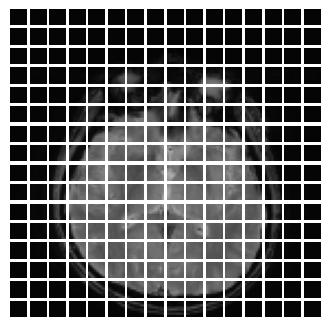

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

In [13]:
def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):

    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    cct_encoded_patches = cct_tokenizer(augmented)

    patches = Patches(patch_size)(augmented)
    # Encode patches.
    default_encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        cct_encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1_c = layers.LayerNormalization(epsilon=1e-5)(cct_encoded_patches)
        x1_d = layers.LayerNormalization(epsilon=1e-5)(default_encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1_c, x1_d)
        attention_output_ = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1_d, x1_c)
        # Global Attension Fusion
        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2_c = layers.concatenate([attention_output, cct_encoded_patches])
        x2_d = layers.concatenate([attention_output_, default_encoded_patches])
        # print(x2_G)
        # Layer normalization 2.
        x3_c = layers.LayerNormalization(epsilon=1e-5)(x2_c)
        x3_d = layers.LayerNormalization(epsilon=1e-5)(x2_d)
        # MLP.
        x3_c = mlp(x3_c, hidden_units=transformer_units, dropout_rate=0.1)
        x3_d = mlp(x3_d, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        x3_c = StochasticDepth(dpr[i])(x3_c)
        cct_encoded_patches = layers.concatenate([x3_c, x2_c])
        x3_d = StochasticDepth(dpr[i])(x3_d)
        default_encoded_patches = layers.concatenate([x3_d, x2_d])
        # print(default_encoded_patches)

    # Apply sequence pooling.
    representation_1 = layers.LayerNormalization(epsilon=1e-5)(cct_encoded_patches)
    attention_weights_1 = tf.nn.softmax(layers.Dense(1)(representation_1), axis=1)
    weighted_representation_1 = tf.matmul(
        attention_weights_1, representation_1, transpose_a=True
    )
    weighted_representation_1 = tf.squeeze(weighted_representation_1, -2)
    # Apply sequence pooling.
    representation_2 = layers.LayerNormalization(epsilon=1e-5)(default_encoded_patches)
    attention_weights_2 = tf.nn.softmax(layers.Dense(1)(representation_2), axis=1)
    weighted_representation_2 = tf.matmul(
        attention_weights_2, representation_2, transpose_a=True
    )
    weighted_representation_2 = tf.squeeze(weighted_representation_2, -2)

    add_=keras.layers.concatenate([weighted_representation_1,weighted_representation_2])
    logits___ = layers.Dense(5,activation='sigmoid')(add_)

    model = keras.Model(inputs=inputs, outputs=logits___)
    return model

In [14]:
cct_model = create_cct_model()
cct_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 128, 128, 3)  0          ['input_1[0][0]']                
                                                                                                  
 cct_tokenizer (CCTTokenizer)   (None, 64, 128)      92592       ['data_augmentation[0][0]']      
                                                                                                  
 patches_1 (Patches)            (None, None, 192)    0           ['data_augmentation[0][0]']  

In [15]:
!pip install -U -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 36.9 MB/s eta 0:00:00


In [17]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def run_experiment(model):
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,loss='categorical_crossentropy',
     metrics=[keras.metrics.CategoricalAccuracy(),keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),keras.metrics.Recall(),
              keras.metrics.Precision(),get_f1, keras.metrics.AUC()],
                )
    model.summary()
    history = model.fit(x_train,y_train,batch_size=32,epochs=200,validation_data=(x_test,y_test))
    model.evaluate(x_test,y_test)
    return history

history = run_experiment(cct_model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 128, 128, 3)  0          ['input_1[0][0]']                
                                                                                                  
 cct_tokenizer (CCTTokenizer)   (None, 64, 128)      92592       ['data_augmentation[0][0]']      
                                                                                                  
 patches_1 (Patches)            (None, None, 192)    0           ['data_augmentation[0][0]']  

In [18]:
cct_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 128, 128, 3)  0          ['input_1[0][0]']                
                                                                                                  
 cct_tokenizer (CCTTokenizer)   (None, 64, 128)      92592       ['data_augmentation[0][0]']      
                                                                                                  
 patches_1 (Patches)            (None, None, 192)    0           ['data_augmentation[0][0]']  

In [19]:
cct_model.evaluate(x_test,y_test)

13/13 [==============================] - 0s 34ms/step - loss: 2.5623 - categorical_accuracy: 0.4394 - top-5-accuracy: 1.0000 - recall_1: 0.6869 - precision_1: 0.3329 - get_f1: 0.4538 - auc_1: 0.7262


[2.5622870922088623,
 0.43939393758773804,
 1.0,
 0.6868686676025391,
 0.33292534947395325,
 0.45380398631095886,
 0.7261592149734497]

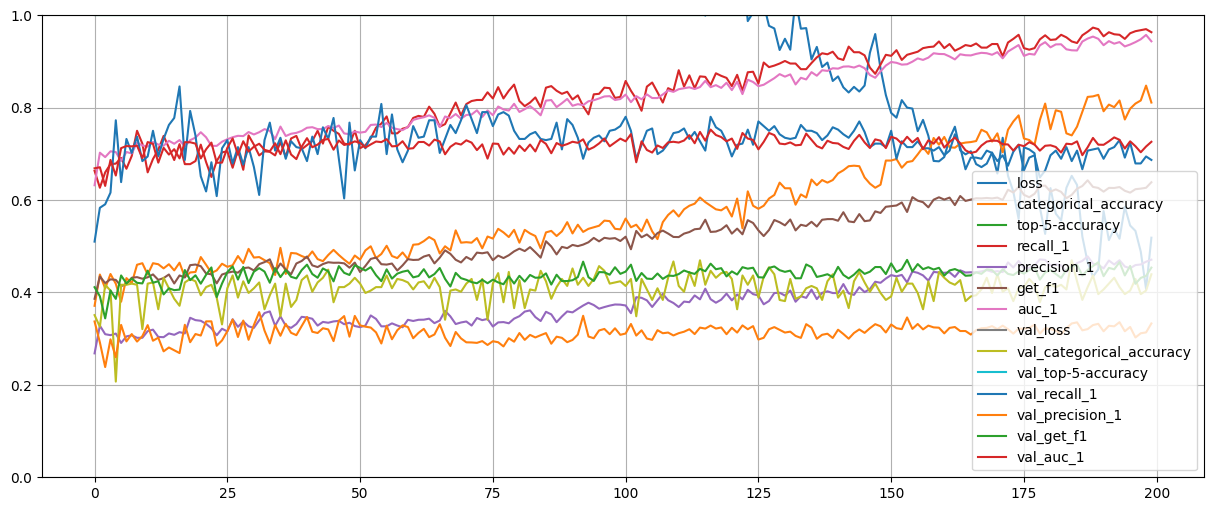

In [20]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_Bivit_with_Aug.pdf")
plt.show()

In [ ]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'top-5-accuracy', 'recall', 'precision', 'get_f1', 'auc', 'val_loss', 'val_categorical_accuracy', 'val_top-5-accuracy', 'val_recall', 'val_precision', 'val_get_f1', 'val_auc'])

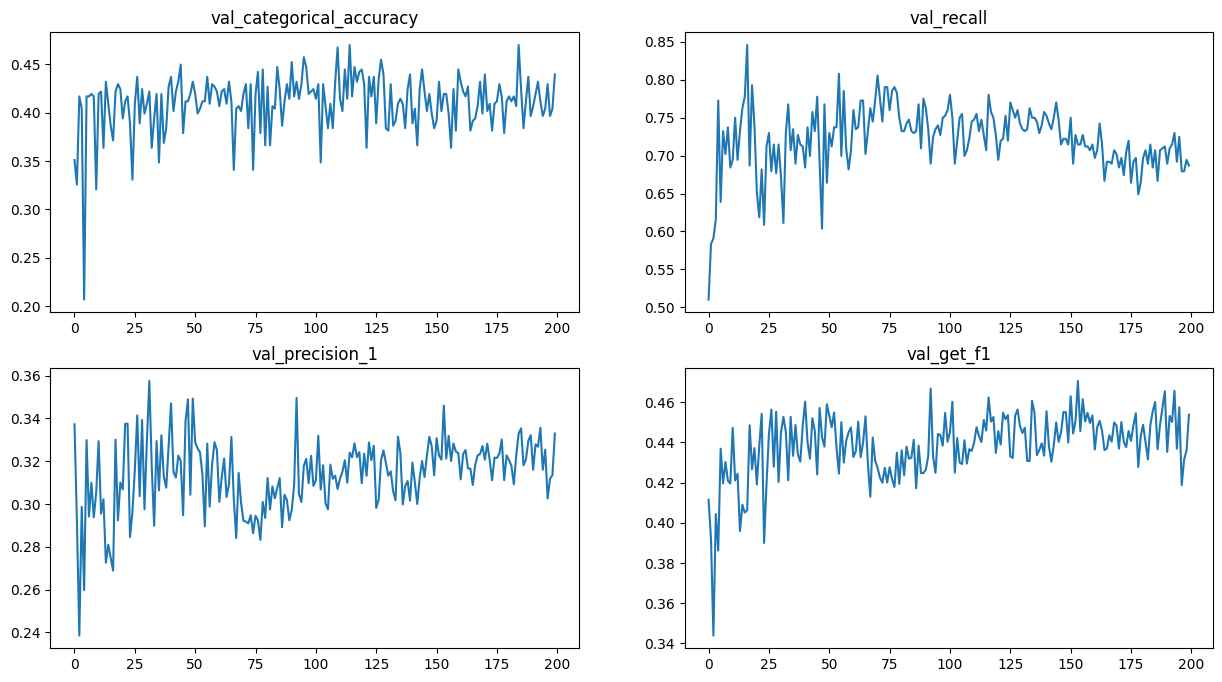

In [22]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,8)
plt.subplot(2,2,1)
plt.plot(history.history['val_categorical_accuracy'])
plt.title('val_categorical_accuracy')
plt.subplot(2,2,2)
plt.plot(history.history['val_recall_1'])
plt.title('val_recall')
plt.subplot(2,2,3)
plt.plot(history.history['val_precision_1'])
plt.title('val_precision_1')
plt.subplot(2,2,4)
plt.plot(history.history['val_get_f1'])
plt.title('val_get_f1')
plt.savefig('cog_seperate_BiViT_graphs.png')
plt.show()

In [23]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(cct_model.predict(x_test),axis=1)))

13/13 [==============================] - 2s 38ms/step
              precision    recall  f1-score   support

           0       0.43      0.34      0.38        61
           1       0.46      0.67      0.54       165
           2       0.39      0.28      0.32        80
           3       0.50      0.04      0.08        24
           4       0.41      0.29      0.34        66

    accuracy                           0.44       396
   macro avg       0.44      0.32      0.33       396
weighted avg       0.43      0.44      0.41       396



In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.argmax(y_test,axis=1),np.argmax(cct_model.predict(x_test),axis=1))

13/13 [==============================] - 0s 32ms/step


array([[ 21,  30,   5,   0,   5],
       [ 19, 111,  22,   0,  13],
       [  4,  46,  22,   1,   7],
       [  1,  17,   3,   1,   2],
       [  4,  39,   4,   0,  19]])

13/13 [==============================] - 0s 32ms/step


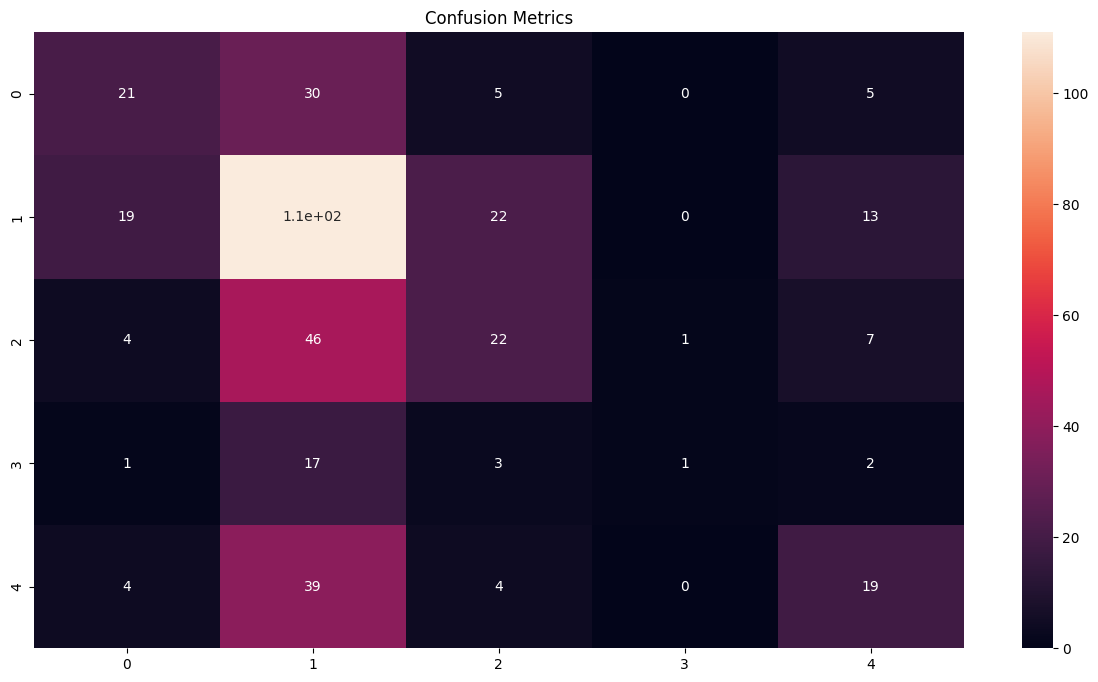

In [25]:
import seaborn as sns
sns.heatmap(confusion_matrix(np.argmax(y_test,axis=1),np.argmax(cct_model.predict(x_test),axis=1)),annot=True)
plt.title('Confusion Metrics')
plt.show()

## Transfer Learning

In [26]:
data_augmentation = keras.Sequential(
    [keras.layers.RandomCrop(128, 128),keras.layers.RandomFlip("horizontal"), keras.layers.RandomTranslation(height_factor=0.2, 
                                width_factor=0.2), keras.layers.RandomZoom(0.5,0.2)],
    name="data_augmentation"
                    )

## DenseNet121

In [27]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.densenet.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(),get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

29084464/29084464 [==============================] - 2s 0us/step


Epoch 1/50
29/29 [==============================] - 16s 253ms/step - loss: 3.8713 - categorical_accuracy: 0.3244 - recall_2: 0.9267 - precision_2: 0.2154 - get_f1: 0.3506 - auc_2: 0.5961 - val_loss: 1.7974 - val_categorical_accuracy: 0.3813 - val_recall_2: 1.0000 - val_precision_2: 0.2000 - val_get_f1: 0.3333 - val_auc_2: 0.5116
Epoch 2/50
29/29 [==============================] - 2s 60ms/step - loss: 2.1740 - categorical_accuracy: 0.3733 - recall_2: 0.9989 - precision_2: 0.2000 - get_f1: 0.3333 - auc_2: 0.5412 - val_loss: 2.6949 - val_categorical_accuracy: 0.4192 - val_recall_2: 1.0000 - val_precision_2: 0.2001 - val_get_f1: 0.3335 - val_auc_2: 0.5111
Epoch 3/50
29/29 [==============================] - 2s 69ms/step - loss: 2.0857 - categorical_accuracy: 0.3778 - recall_2: 1.0000 - precision_2: 0.2002 - get_f1: 0.3336 - auc_2: 0.5446 - val_loss: 2.8304 - val_categorical_accuracy: 0.4217 - val_recall_2: 1.0000 - val_precision_2: 0.2001 - val_get_f1: 0.3335 - val_auc_2: 0.5047
Epoch 4/50


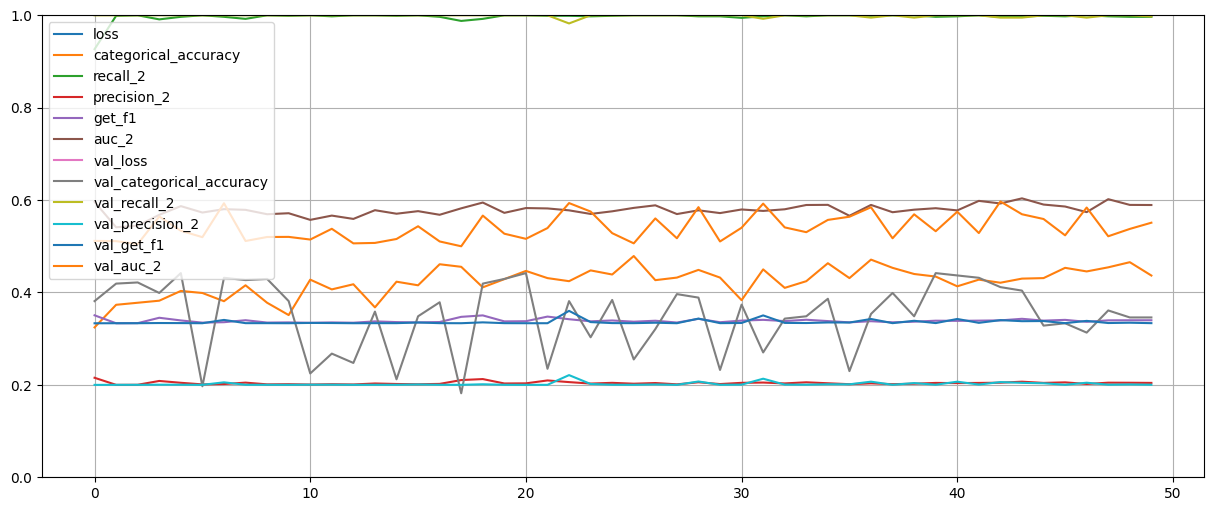

In [28]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_Densenet121_with_Aug.png")
plt.show()

In [29]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 2s 39ms/step
              precision    recall  f1-score   support

           0       0.62      0.16      0.26        61
           1       0.57      0.30      0.40       165
           2       0.26      0.89      0.40        80
           3       1.00      0.04      0.08        24
           4       0.33      0.08      0.12        66

    accuracy                           0.35       396
   macro avg       0.56      0.29      0.25       396
weighted avg       0.50      0.35      0.31       396



In [30]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_2']))
print(np.std(history.history['val_precision_2']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_2']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_2']))
print(np.mean(history.history['val_precision_2']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_2']))

0.07314590704814163
0.0029917551248334956
0.003804494365345916
0.004860293400742531
0.028428031506613622
0.3508585858345032
0.9989393961429596
0.20200451731681823
0.3359235858917236
0.5405150175094604


## Resnet 50

In [31]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(),get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

94765736/94765736 [==============================] - 5s 0us/step


Epoch 1/50
29/29 [==============================] - 9s 153ms/step - loss: 1.5356 - categorical_accuracy: 0.4011 - recall_3: 0.6389 - precision_3: 0.2982 - get_f1: 0.4049 - auc_3: 0.6820 - val_loss: 1.4815 - val_categorical_accuracy: 0.4167 - val_recall_3: 0.7652 - val_precision_3: 0.2574 - val_get_f1: 0.3826 - val_auc_3: 0.6886
Epoch 2/50
29/29 [==============================] - 2s 64ms/step - loss: 1.4791 - categorical_accuracy: 0.4422 - recall_3: 0.6678 - precision_3: 0.2861 - get_f1: 0.3956 - auc_3: 0.6949 - val_loss: 1.4468 - val_categorical_accuracy: 0.4293 - val_recall_3: 0.5758 - val_precision_3: 0.2886 - val_get_f1: 0.3846 - val_auc_3: 0.6824
Epoch 3/50
29/29 [==============================] - 2s 63ms/step - loss: 1.4093 - categorical_accuracy: 0.4622 - recall_3: 0.6900 - precision_3: 0.2935 - get_f1: 0.4062 - auc_3: 0.7173 - val_loss: 1.4308 - val_categorical_accuracy: 0.4293 - val_recall_3: 0.7854 - val_precision_3: 0.2787 - val_get_f1: 0.4104 - val_auc_3: 0.7077
Epoch 4/50
2

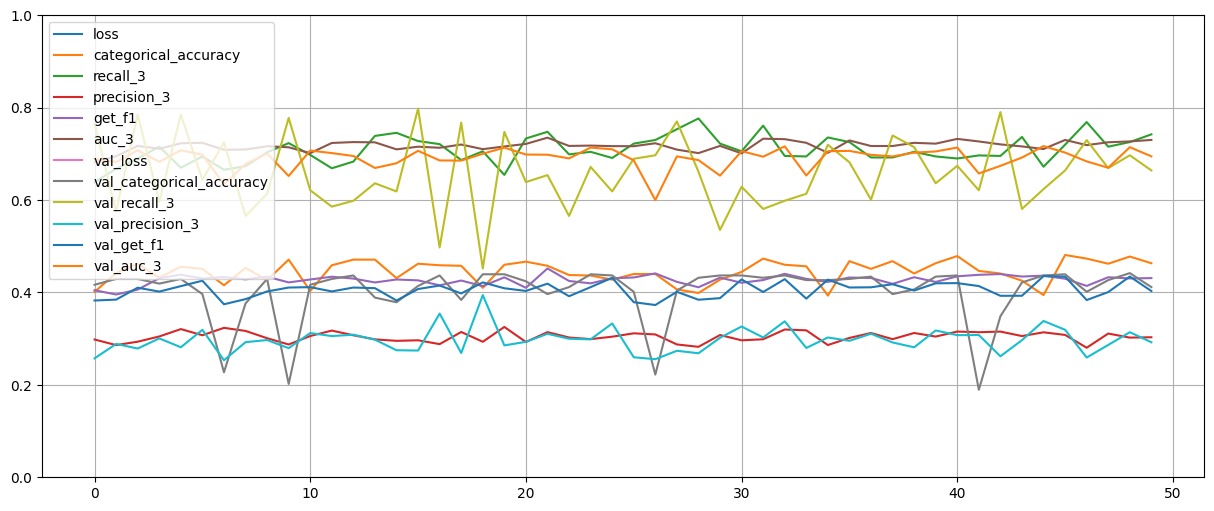

In [32]:
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_Resnet50_with_Aug.png")
plt.show()

In [33]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 4s 42ms/step
              precision    recall  f1-score   support

           0       0.27      0.18      0.22        61
           1       0.43      0.92      0.58       165
           2       0.33      0.01      0.02        80
           3       0.00      0.00      0.00        24
           4       0.00      0.00      0.00        66

    accuracy                           0.41       396
   macro avg       0.21      0.22      0.16       396
weighted avg       0.29      0.41      0.28       396



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_3']))
print(np.std(history.history['val_precision_3']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_3']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_3']))
print(np.mean(history.history['val_precision_3']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_3']))

0.06028799113469564
0.07851584550968495
0.02657502700232363
0.016478306515240983
0.022509962833743874
0.402777778506279
0.6577777767181396
0.2969831883907318
0.4058130759000778
0.6902063071727753


## VGG16

In [35]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

58889256/58889256 [==============================] - 4s 0us/step


Epoch 1/50
29/29 [==============================] - 10s 180ms/step - loss: 1.5395 - categorical_accuracy: 0.3900 - recall_4: 0.7056 - precision_4: 0.2863 - get_f1: 0.4154 - auc_4: 0.6878 - val_loss: 1.6485 - val_categorical_accuracy: 0.4192 - val_recall_4: 0.5859 - val_precision_4: 0.3422 - val_get_f1: 0.4325 - val_auc_4: 0.7004
Epoch 2/50
29/29 [==============================] - 2s 69ms/step - loss: 1.4342 - categorical_accuracy: 0.4489 - recall_4: 0.6722 - precision_4: 0.3020 - get_f1: 0.4143 - auc_4: 0.7144 - val_loss: 1.5060 - val_categorical_accuracy: 0.4268 - val_recall_4: 0.7121 - val_precision_4: 0.2616 - val_get_f1: 0.3857 - val_auc_4: 0.6885
Epoch 3/50
29/29 [==============================] - 2s 73ms/step - loss: 1.4341 - categorical_accuracy: 0.4422 - recall_4: 0.6800 - precision_4: 0.3201 - get_f1: 0.4361 - auc_4: 0.7134 - val_loss: 1.5560 - val_categorical_accuracy: 0.4318 - val_recall_4: 0.6086 - val_precision_4: 0.2622 - val_get_f1: 0.3688 - val_auc_4: 0.6413
Epoch 4/50


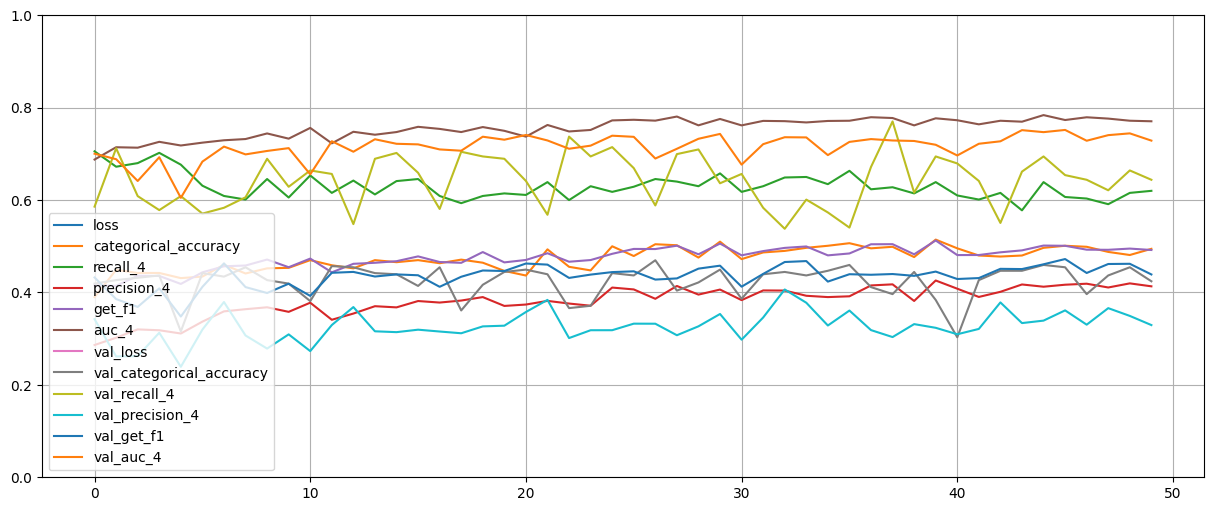

In [36]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_VGG16_with_Aug.pdf")
plt.show()

In [37]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 1s 45ms/step
              precision    recall  f1-score   support

           0       0.35      0.43      0.38        61
           1       0.46      0.82      0.59       165
           2       0.50      0.01      0.02        80
           3       0.50      0.04      0.08        24
           4       0.19      0.06      0.09        66

    accuracy                           0.42       396
   macro avg       0.40      0.27      0.23       396
weighted avg       0.41      0.42      0.33       396



In [38]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_4']))
print(np.std(history.history['val_precision_4']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_4']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_4']))
print(np.mean(history.history['val_precision_4']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_4']))

0.03481860769541885
0.055669967515471715
0.03232921219884457
0.024818225284757835
0.027777016388653642
0.4244444459676743
0.6423737347126007
0.32718306928873064
0.43480208396911624
0.7156358385086059


## IncepTionResnetV2

In [39]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

219055592/219055592 [==============================] - 12s 0us/step


Epoch 1/50
29/29 [==============================] - 30s 407ms/step - loss: 2.9121 - categorical_accuracy: 0.3144 - recall_5: 0.8978 - precision_5: 0.2231 - get_f1: 0.3600 - auc_5: 0.6224 - val_loss: 2.1371 - val_categorical_accuracy: 0.3460 - val_recall_5: 0.9444 - val_precision_5: 0.2091 - val_get_f1: 0.3426 - val_auc_5: 0.6293
Epoch 2/50
29/29 [==============================] - 4s 124ms/step - loss: 1.9744 - categorical_accuracy: 0.3611 - recall_5: 0.9811 - precision_5: 0.2093 - get_f1: 0.3448 - auc_5: 0.6424 - val_loss: 1.8155 - val_categorical_accuracy: 0.3561 - val_recall_5: 0.9848 - val_precision_5: 0.2005 - val_get_f1: 0.3332 - val_auc_5: 0.6187
Epoch 3/50
29/29 [==============================] - 3s 104ms/step - loss: 2.0400 - categorical_accuracy: 0.3456 - recall_5: 0.9778 - precision_5: 0.2105 - get_f1: 0.3478 - auc_5: 0.6407 - val_loss: 2.0716 - val_categorical_accuracy: 0.3258 - val_recall_5: 0.9495 - val_precision_5: 0.2262 - val_get_f1: 0.3644 - val_auc_5: 0.6516
Epoch 4/5

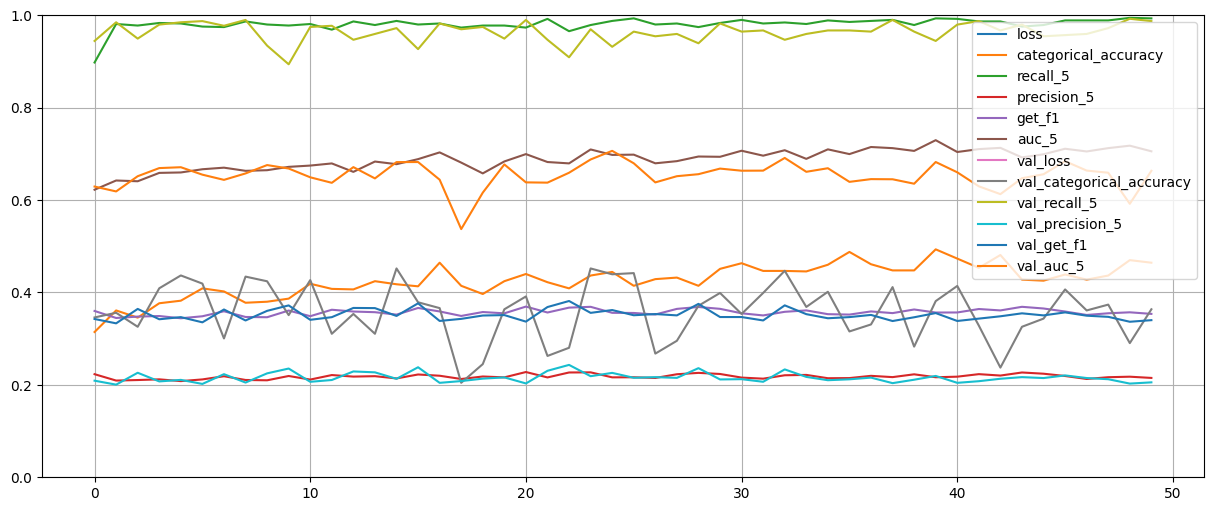

In [40]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_InceptionResnetV2_with_Aug.pdf")
plt.show()

In [41]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 4s 65ms/step
              precision    recall  f1-score   support

           0       0.42      0.21      0.28        61
           1       0.45      0.58      0.51       165
           2       0.28      0.34      0.31        80
           3       0.10      0.17      0.13        24
           4       0.24      0.06      0.10        66

    accuracy                           0.36       396
   macro avg       0.30      0.27      0.26       396
weighted avg       0.35      0.36      0.34       396



In [42]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_5']))
print(np.std(history.history['val_precision_5']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_5']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_5']))
print(np.mean(history.history['val_precision_5']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_5']))

0.060857412717272255
0.02086048044313636
0.010242507027430967
0.011723300401194913
0.027346322326997803
0.3590404030680656
0.9636363625526428
0.21566713243722915
0.35137259066104887
0.6534546542167664


## InceptionV3

In [43]:
import tensorflow as tf

data_augmentation = keras.Sequential(
    [keras.layers.RandomCrop(128, 128),keras.layers.RandomFlip("horizontal"), keras.layers.RandomTranslation(height_factor=0.2, 
                                width_factor=0.2), keras.layers.RandomZoom(0.5,0.2)],
    name="data_augmentation"
                    )

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

87910968/87910968 [==============================] - 5s 0us/step


Epoch 1/50
29/29 [==============================] - 12s 196ms/step - loss: 4.4529 - categorical_accuracy: 0.2878 - recall_6: 0.9300 - precision_6: 0.2231 - get_f1: 0.3612 - auc_6: 0.5953 - val_loss: 3.3767 - val_categorical_accuracy: 0.1742 - val_recall_6: 0.9975 - val_precision_6: 0.2047 - val_get_f1: 0.3394 - val_auc_6: 0.5892
Epoch 2/50
29/29 [==============================] - 1s 45ms/step - loss: 2.6113 - categorical_accuracy: 0.3344 - recall_6: 1.0000 - precision_6: 0.2009 - get_f1: 0.3350 - auc_6: 0.5491 - val_loss: 3.8620 - val_categorical_accuracy: 0.4066 - val_recall_6: 0.9949 - val_precision_6: 0.2046 - val_get_f1: 0.3395 - val_auc_6: 0.5657
Epoch 3/50
29/29 [==============================] - 2s 54ms/step - loss: 2.8874 - categorical_accuracy: 0.3478 - recall_6: 0.9944 - precision_6: 0.2009 - get_f1: 0.3343 - auc_6: 0.5440 - val_loss: 2.1945 - val_categorical_accuracy: 0.3712 - val_recall_6: 1.0000 - val_precision_6: 0.2001 - val_get_f1: 0.3335 - val_auc_6: 0.5372
Epoch 4/50


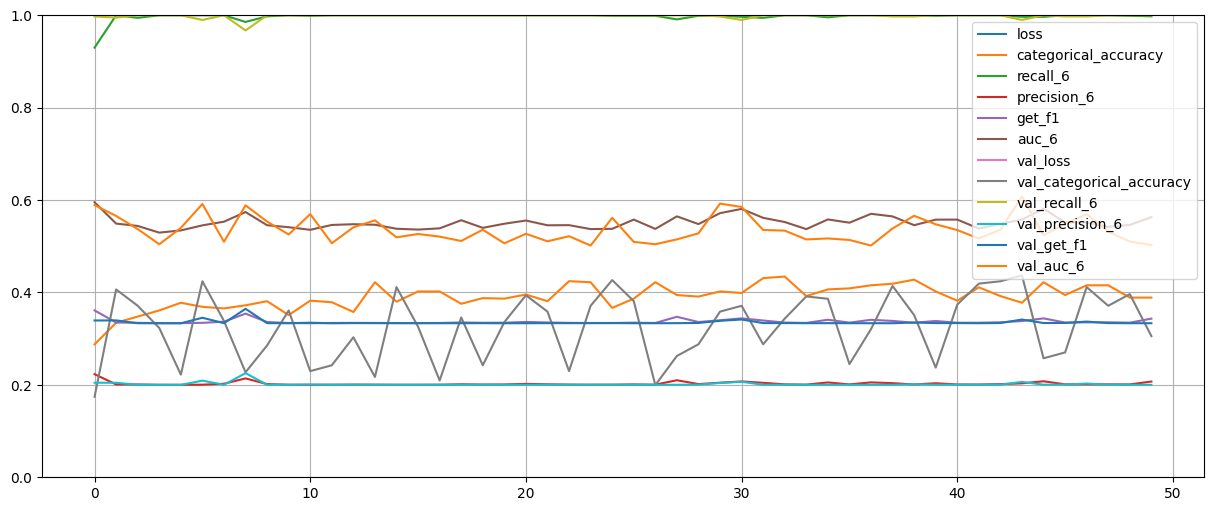

In [44]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_InceptionV3_with_Aug.pdf")
plt.show()

In [45]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 2s 34ms/step
              precision    recall  f1-score   support

           0       0.23      0.46      0.30        61
           1       0.50      0.46      0.48       165
           2       0.20      0.09      0.12        80
           3       0.12      0.42      0.18        24
           4       0.00      0.00      0.00        66

    accuracy                           0.31       396
   macro avg       0.21      0.28      0.22       396
weighted avg       0.29      0.31      0.28       396



In [46]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_6']))
print(np.std(history.history['val_precision_6']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_6']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_6']))
print(np.mean(history.history['val_precision_6']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_6']))

0.07273246620914753
0.005115989250911471
0.0039493408884550656
0.004910050792502971
0.027930399126399212
0.3256565672159195
0.9983333313465118
0.20147685080766678
0.33520486295223234
0.5361532056331635


## EfficientNetB0

In [47]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

16705208/16705208 [==============================] - 2s 0us/step


Epoch 1/50
29/29 [==============================] - 18s 324ms/step - loss: 2.4759 - categorical_accuracy: 0.3356 - recall_7: 0.9200 - precision_7: 0.2248 - get_f1: 0.3656 - auc_7: 0.6246 - val_loss: 1.7753 - val_categorical_accuracy: 0.4167 - val_recall_7: 1.0000 - val_precision_7: 0.2000 - val_get_f1: 0.3333 - val_auc_7: 0.6305
Epoch 2/50
29/29 [==============================] - 2s 58ms/step - loss: 1.6412 - categorical_accuracy: 0.3811 - recall_7: 0.9933 - precision_7: 0.2033 - get_f1: 0.3400 - auc_7: 0.6736 - val_loss: 1.5632 - val_categorical_accuracy: 0.4167 - val_recall_7: 0.9394 - val_precision_7: 0.2348 - val_get_f1: 0.3737 - val_auc_7: 0.6900
Epoch 3/50
29/29 [==============================] - 1s 46ms/step - loss: 1.6670 - categorical_accuracy: 0.3822 - recall_7: 1.0000 - precision_7: 0.2011 - get_f1: 0.3350 - auc_7: 0.6536 - val_loss: 1.6711 - val_categorical_accuracy: 0.1667 - val_recall_7: 1.0000 - val_precision_7: 0.2000 - val_get_f1: 0.3333 - val_auc_7: 0.6067
Epoch 4/50


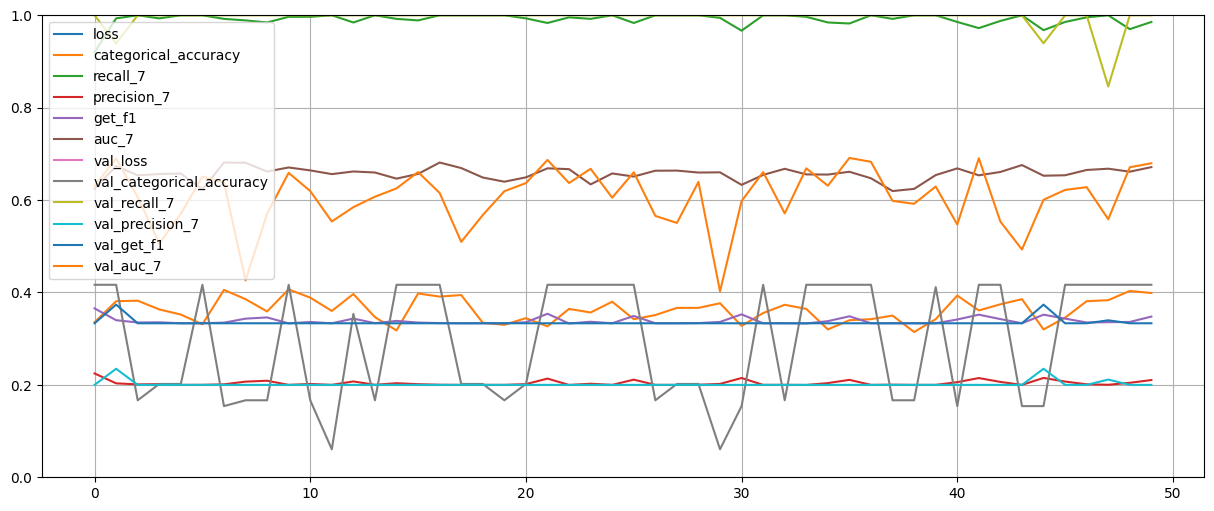

In [48]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_EfficientNetB0_with_Aug.pdf")
plt.show()

In [49]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 4s 35ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.42      1.00      0.59       165
           2       0.00      0.00      0.00        80
           3       0.00      0.00      0.00        24
           4       0.00      0.00      0.00        66

    accuracy                           0.42       396
   macro avg       0.08      0.20      0.12       396
weighted avg       0.17      0.42      0.25       396



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_7']))
print(np.std(history.history['val_precision_7']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_7']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_7']))
print(np.mean(history.history['val_precision_7']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_7']))

0.12702199348614887
0.024314339086680372
0.006969971222391001
0.007938420808515341
0.06327625889279152
0.294747471511364
0.9944949495792389
0.20162374019622803
0.3350768756866455
0.6065676301717758


## EfficientNetB1

In [51]:
import tensorflow as tf

data_augmentation = keras.Sequential(
    [keras.layers.RandomCrop(128, 128),keras.layers.RandomFlip("horizontal"), keras.layers.RandomTranslation(height_factor=0.2, 
                                width_factor=0.2), keras.layers.RandomZoom(0.5,0.2)],
    name="data_augmentation"
                    )

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

27018416/27018416 [==============================] - 2s 0us/step


Epoch 1/50
29/29 [==============================] - 21s 219ms/step - loss: 3.4262 - categorical_accuracy: 0.3322 - recall_8: 0.8167 - precision_8: 0.2262 - get_f1: 0.3528 - auc_8: 0.5934 - val_loss: 3.7770 - val_categorical_accuracy: 0.1667 - val_recall_8: 1.0000 - val_precision_8: 0.2000 - val_get_f1: 0.3333 - val_auc_8: 0.5030
Epoch 2/50
29/29 [==============================] - 2s 74ms/step - loss: 2.0835 - categorical_accuracy: 0.3156 - recall_8: 0.9756 - precision_8: 0.2006 - get_f1: 0.3327 - auc_8: 0.6245 - val_loss: 1.8153 - val_categorical_accuracy: 0.4167 - val_recall_8: 1.0000 - val_precision_8: 0.2000 - val_get_f1: 0.3333 - val_auc_8: 0.5225
Epoch 3/50
29/29 [==============================] - 2s 73ms/step - loss: 1.5708 - categorical_accuracy: 0.4067 - recall_8: 1.0000 - precision_8: 0.2000 - get_f1: 0.3333 - auc_8: 0.6674 - val_loss: 1.5706 - val_categorical_accuracy: 0.2020 - val_recall_8: 1.0000 - val_precision_8: 0.2000 - val_get_f1: 0.3333 - val_auc_8: 0.6276
Epoch 4/50


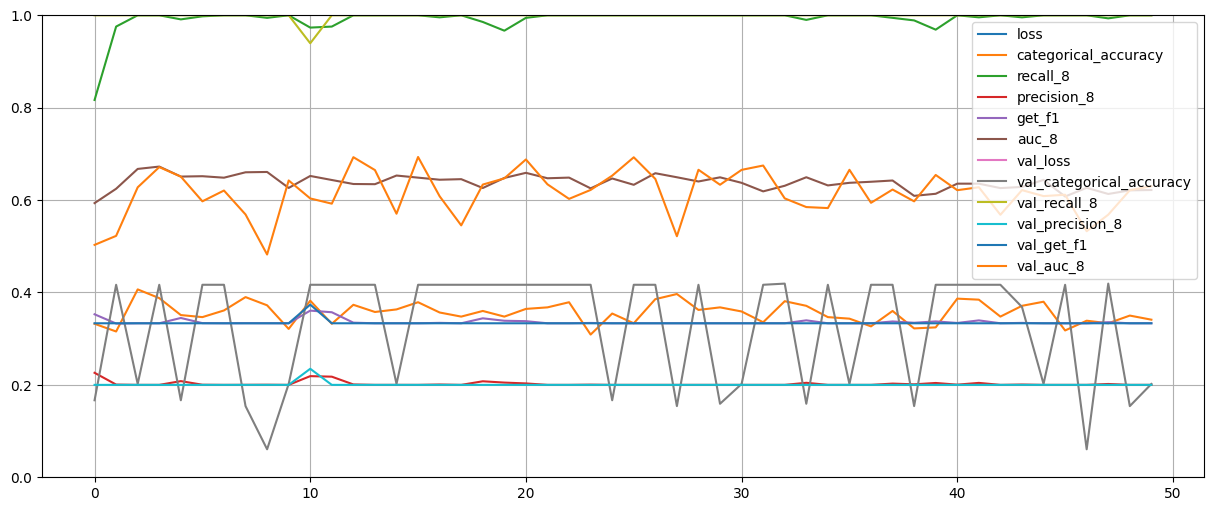

In [52]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_EfficientB1_with_Aug.png")
plt.show()

In [53]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 3s 39ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.00      0.00      0.00       165
           2       0.20      1.00      0.34        80
           3       0.00      0.00      0.00        24
           4       0.00      0.00      0.00        66

    accuracy                           0.20       396
   macro avg       0.04      0.20      0.07       396
weighted avg       0.04      0.20      0.07       396



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_8']))
print(np.std(history.history['val_precision_8']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_8']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_8']))
print(np.mean(history.history['val_precision_8']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_8']))

0.1229777605308736
0.008484848737716676
0.004878787398338319
0.005653851032257079
0.04916856240483765
0.3252020147442818
0.9987878787517548
0.20069697260856628
0.33414097666740417
0.6150630164146423


## VGG19

In [56]:
import tensorflow as tf

data_augmentation = keras.Sequential(
    [keras.layers.RandomCrop(128, 128),keras.layers.RandomFlip("horizontal"), keras.layers.RandomTranslation(height_factor=0.2, 
                                width_factor=0.2), keras.layers.RandomZoom(0.5,0.2)],
    name="data_augmentation"
                    )

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

80134624/80134624 [==============================] - 4s 0us/step


Epoch 1/50
29/29 [==============================] - 7s 140ms/step - loss: 1.5831 - categorical_accuracy: 0.3911 - recall_9: 0.8378 - precision_9: 0.2482 - get_f1: 0.3887 - auc_9: 0.6780 - val_loss: 1.5080 - val_categorical_accuracy: 0.4268 - val_recall_9: 0.7702 - val_precision_9: 0.2576 - val_get_f1: 0.3886 - val_auc_9: 0.6820
Epoch 2/50
29/29 [==============================] - 2s 83ms/step - loss: 1.4519 - categorical_accuracy: 0.4333 - recall_9: 0.8522 - precision_9: 0.2574 - get_f1: 0.3955 - auc_9: 0.7073 - val_loss: 1.4718 - val_categorical_accuracy: 0.4242 - val_recall_9: 0.8283 - val_precision_9: 0.2599 - val_get_f1: 0.3954 - val_auc_9: 0.6984
Epoch 3/50
29/29 [==============================] - 2s 83ms/step - loss: 1.4262 - categorical_accuracy: 0.4567 - recall_9: 0.8578 - precision_9: 0.2605 - get_f1: 0.3984 - auc_9: 0.7287 - val_loss: 1.5463 - val_categorical_accuracy: 0.3510 - val_recall_9: 0.9066 - val_precision_9: 0.2095 - val_get_f1: 0.3413 - val_auc_9: 0.6249
Epoch 4/50
2

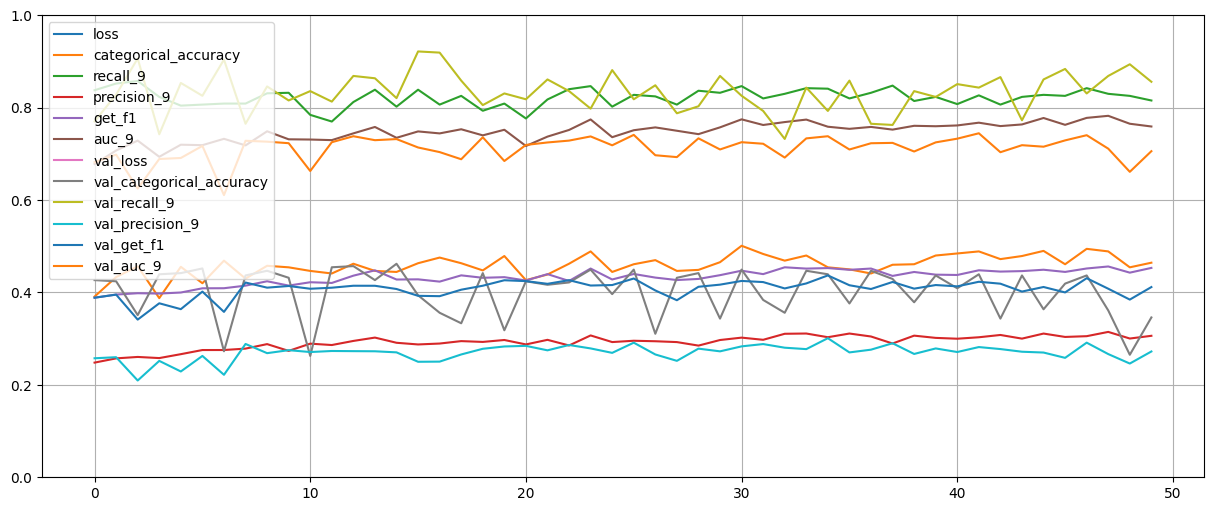

In [57]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_VGG19_with_Aug.png")
plt.show()

In [58]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 1s 54ms/step
              precision    recall  f1-score   support

           0       0.26      0.49      0.34        61
           1       0.45      0.57      0.50       165
           2       0.00      0.00      0.00        80
           3       0.00      0.00      0.00        24
           4       0.20      0.20      0.20        66

    accuracy                           0.35       396
   macro avg       0.18      0.25      0.21       396
weighted avg       0.26      0.35      0.29       396



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_9']))
print(np.std(history.history['val_precision_9']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_9']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_9']))
print(np.mean(history.history['val_precision_9']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_9']))

0.05306867392914776
0.0435365220959951
0.01717627447696583
0.018498720991130334
0.027278403653983953
0.40161616206169126
0.8335353529453278
0.2697394779324532
0.40789340138435365
0.7114044225215912


## Resnet101

In [60]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.resnet.ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

171446536/171446536 [==============================] - 9s 0us/step


Epoch 1/50
29/29 [==============================] - 20s 265ms/step - loss: 1.4424 - categorical_accuracy: 0.4522 - recall_10: 0.7044 - precision_10: 0.2895 - get_f1: 0.4154 - auc_10: 0.7067 - val_loss: 1.5187 - val_categorical_accuracy: 0.4369 - val_recall_10: 0.7374 - val_precision_10: 0.2458 - val_get_f1: 0.3690 - val_auc_10: 0.6757
Epoch 2/50
29/29 [==============================] - 3s 121ms/step - loss: 1.4262 - categorical_accuracy: 0.4589 - recall_10: 0.7422 - precision_10: 0.2931 - get_f1: 0.4261 - auc_10: 0.7172 - val_loss: 1.4657 - val_categorical_accuracy: 0.4192 - val_recall_10: 0.6237 - val_precision_10: 0.3005 - val_get_f1: 0.4075 - val_auc_10: 0.6998
Epoch 3/50
29/29 [==============================] - 3s 119ms/step - loss: 1.4114 - categorical_accuracy: 0.4433 - recall_10: 0.6878 - precision_10: 0.3123 - get_f1: 0.4386 - auc_10: 0.7241 - val_loss: 1.5154 - val_categorical_accuracy: 0.4394 - val_recall_10: 0.4646 - val_precision_10: 0.3882 - val_get_f1: 0.4258 - val_auc_10

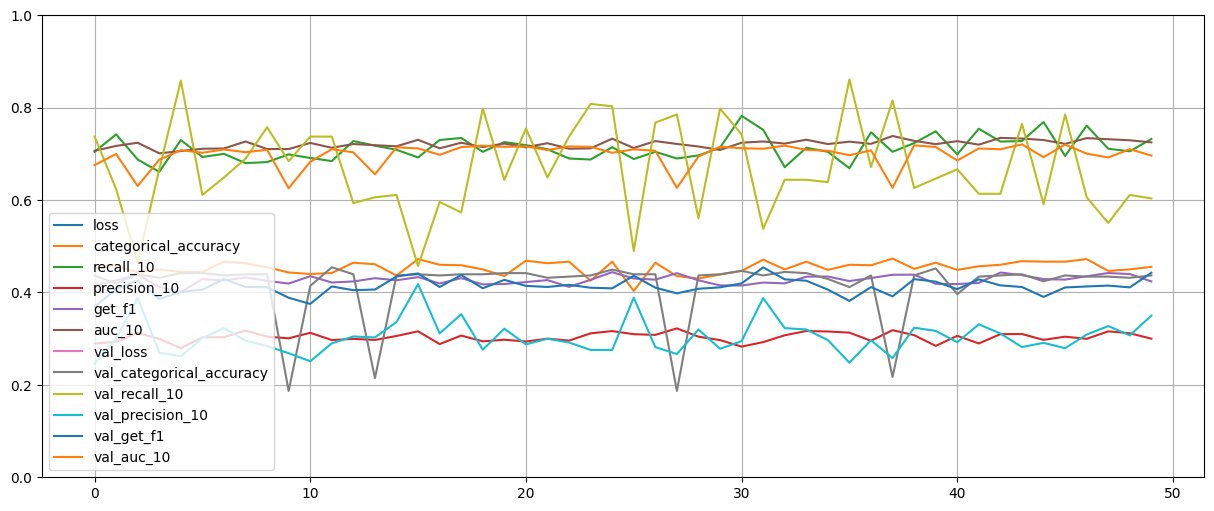

In [61]:
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_Resnet101_with_Aug.png")
plt.show()

In [62]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 4s 63ms/step
              precision    recall  f1-score   support

           0       1.00      0.13      0.23        61
           1       0.43      1.00      0.60       165
           2       0.00      0.00      0.00        80
           3       0.00      0.00      0.00        24
           4       0.00      0.00      0.00        66

    accuracy                           0.44       396
   macro avg       0.29      0.23      0.17       396
weighted avg       0.33      0.44      0.28       396



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_10']))
print(np.std(history.history['val_precision_10']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_10']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_10']))
print(np.mean(history.history['val_precision_10']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_10']))

0.0645019112181392
0.09750875475273314
0.03650960977813242
0.016757989523110414
0.024362123339122667
0.41732323318719866
0.6696969664096832
0.3042978420853615
0.41281961023807523
0.6989481580257416


## MobileNet

In [64]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.mobilenet.MobileNet(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

17225924/17225924 [==============================] - 2s 0us/step


Epoch 1/50
29/29 [==============================] - 7s 130ms/step - loss: 3.7200 - categorical_accuracy: 0.3189 - recall_11: 0.8800 - precision_11: 0.2248 - get_f1: 0.3603 - auc_11: 0.6348 - val_loss: 2.2649 - val_categorical_accuracy: 0.3990 - val_recall_11: 0.9697 - val_precision_11: 0.2220 - val_get_f1: 0.3602 - val_auc_11: 0.6540
Epoch 2/50
29/29 [==============================] - 1s 37ms/step - loss: 2.7596 - categorical_accuracy: 0.4033 - recall_11: 0.9478 - precision_11: 0.2224 - get_f1: 0.3604 - auc_11: 0.6571 - val_loss: 3.0736 - val_categorical_accuracy: 0.4394 - val_recall_11: 0.9899 - val_precision_11: 0.2037 - val_get_f1: 0.3380 - val_auc_11: 0.6348
Epoch 3/50
29/29 [==============================] - 1s 32ms/step - loss: 2.5405 - categorical_accuracy: 0.3911 - recall_11: 0.9744 - precision_11: 0.2095 - get_f1: 0.3446 - auc_11: 0.6476 - val_loss: 2.4720 - val_categorical_accuracy: 0.3914 - val_recall_11: 0.9848 - val_precision_11: 0.2074 - val_get_f1: 0.3430 - val_auc_11: 0

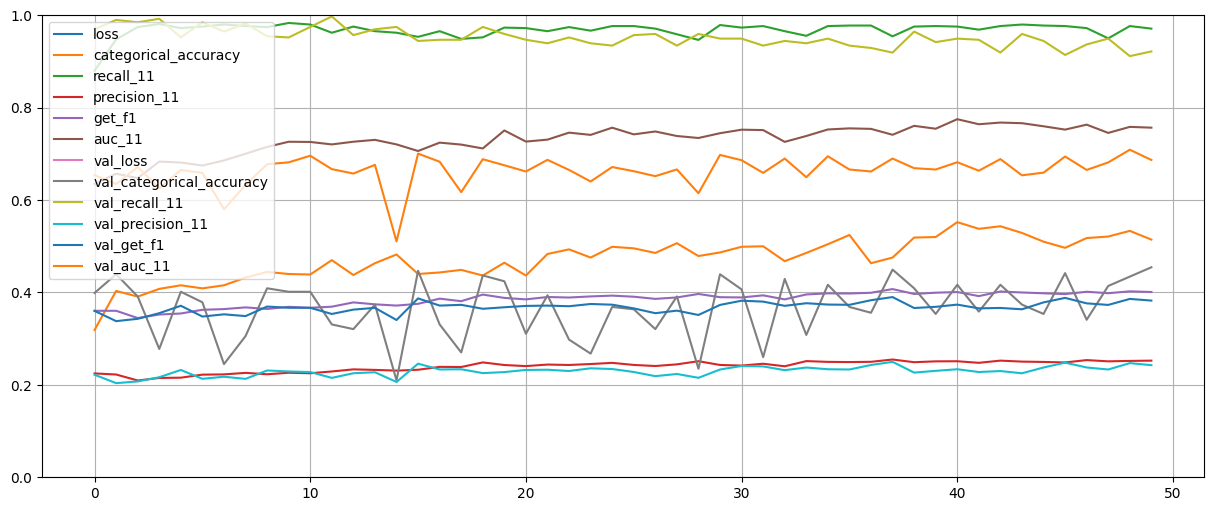

In [65]:
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_Mobilenet_with_Aug.png")
plt.show()

In [66]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0       0.44      0.31      0.37        61
           1       0.49      0.76      0.59       165
           2       0.37      0.40      0.39        80
           3       0.00      0.00      0.00        24
           4       0.40      0.06      0.11        66

    accuracy                           0.45       396
   macro avg       0.34      0.31      0.29       396
weighted avg       0.41      0.45      0.40       396



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_11']))
print(np.std(history.history['val_precision_11']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_11']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_11']))
print(np.mean(history.history['val_precision_11']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_11']))

0.062308269946592866
0.02000510417860983
0.010556246376705427
0.012055198360872866
0.03262149255096287
0.36691919147968294
0.9521212148666381
0.22937095046043396
0.36792672514915464
0.6637843549251556


In [68]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

83683744/83683744 [==============================] - 6s 0us/step


Epoch 1/50
29/29 [==============================] - 10s 173ms/step - loss: 3.7916 - categorical_accuracy: 0.3289 - recall_12: 0.9111 - precision_12: 0.2280 - get_f1: 0.3650 - auc_12: 0.6049 - val_loss: 2.5181 - val_categorical_accuracy: 0.2020 - val_recall_12: 0.9975 - val_precision_12: 0.1999 - val_get_f1: 0.3331 - val_auc_12: 0.5238
Epoch 2/50
29/29 [==============================] - 2s 70ms/step - loss: 2.4599 - categorical_accuracy: 0.3389 - recall_12: 0.9778 - precision_12: 0.2115 - get_f1: 0.3482 - auc_12: 0.6199 - val_loss: 2.5223 - val_categorical_accuracy: 0.3737 - val_recall_12: 0.9924 - val_precision_12: 0.2015 - val_get_f1: 0.3352 - val_auc_12: 0.6443
Epoch 3/50
29/29 [==============================] - 2s 73ms/step - loss: 2.2222 - categorical_accuracy: 0.3744 - recall_12: 0.9933 - precision_12: 0.2043 - get_f1: 0.3393 - auc_12: 0.6024 - val_loss: 3.0136 - val_categorical_accuracy: 0.4141 - val_recall_12: 1.0000 - val_precision_12: 0.2032 - val_get_f1: 0.3380 - val_auc_12: 

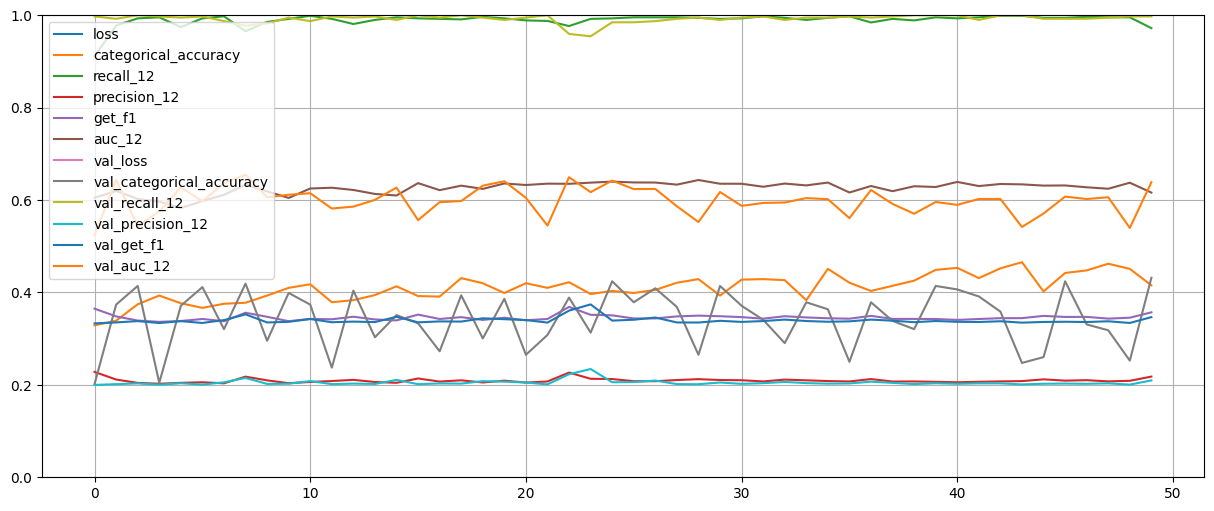

In [69]:
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_Xception_with_Aug.png")
plt.show()

In [70]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 2s 51ms/step
              precision    recall  f1-score   support

           0       0.86      0.10      0.18        61
           1       0.43      0.95      0.59       165
           2       0.35      0.07      0.12        80
           3       0.00      0.00      0.00        24
           4       0.25      0.05      0.08        66

    accuracy                           0.43       396
   macro avg       0.38      0.23      0.19       396
weighted avg       0.43      0.43      0.31       396



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_12']))
print(np.std(history.history['val_precision_12']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_12']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_12']))
print(np.mean(history.history['val_precision_12']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_12']))

0.06199996559888804
0.008846893193423732
0.005784545788979448
0.007013935601671227
0.03069879876202086
0.34343434393405914
0.9926262640953064
0.20489231646060943
0.3394007182121277
0.5988145160675049


## ResNet152

In [72]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.resnet.ResNet152(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
Inp_=keras.layers.Input(shape=(128,128,3))
augmentation = data_augmentation(Inp_)
output = keras.layers.Flatten()(model(augmentation))
out = keras.layers.Dense(5,activation='sigmoid')(output)
classifier = keras.models.Model([Inp_], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

234698864/234698864 [==============================] - 14s 0us/step


Epoch 1/50
29/29 [==============================] - 28s 378ms/step - loss: 1.5325 - categorical_accuracy: 0.4011 - recall_13: 0.6789 - precision_13: 0.2900 - get_f1: 0.4066 - auc_13: 0.6834 - val_loss: 1.5228 - val_categorical_accuracy: 0.4167 - val_recall_13: 0.5556 - val_precision_13: 0.2965 - val_get_f1: 0.3869 - val_auc_13: 0.6773
Epoch 2/50
29/29 [==============================] - 4s 148ms/step - loss: 1.5141 - categorical_accuracy: 0.3989 - recall_13: 0.6278 - precision_13: 0.3111 - get_f1: 0.4199 - auc_13: 0.6826 - val_loss: 1.4786 - val_categorical_accuracy: 0.4217 - val_recall_13: 0.7929 - val_precision_13: 0.2675 - val_get_f1: 0.3990 - val_auc_13: 0.6883
Epoch 3/50
29/29 [==============================] - 4s 146ms/step - loss: 1.4230 - categorical_accuracy: 0.4622 - recall_13: 0.7067 - precision_13: 0.3029 - get_f1: 0.4309 - auc_13: 0.7170 - val_loss: 1.4768 - val_categorical_accuracy: 0.4293 - val_recall_13: 0.7727 - val_precision_13: 0.2777 - val_get_f1: 0.4081 - val_auc_13

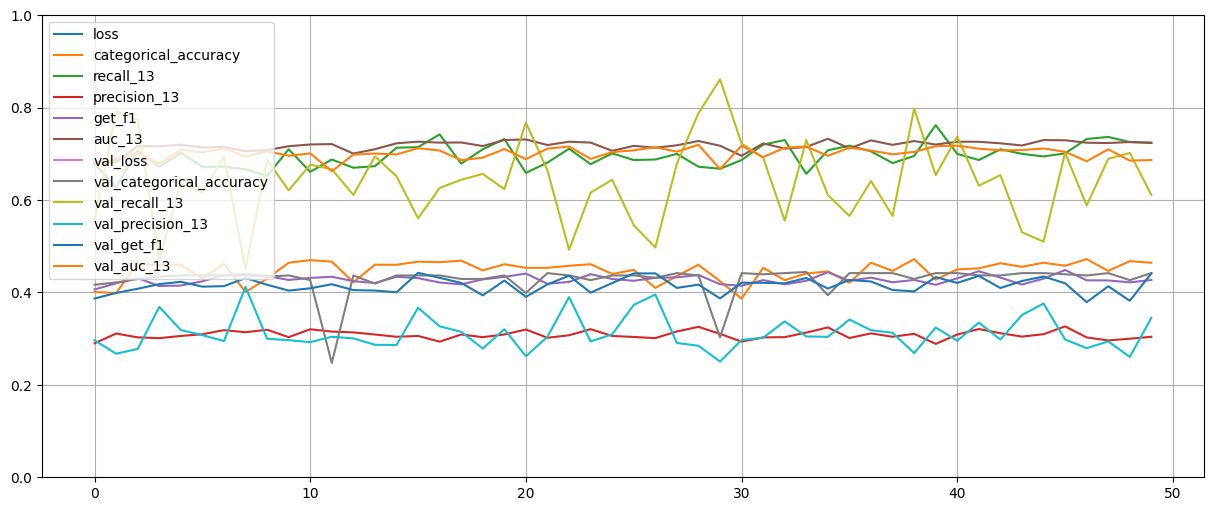

In [73]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("cog_Resnet152_with_Aug.png")
plt.show()

In [74]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

13/13 [==============================] - 6s 85ms/step
              precision    recall  f1-score   support

           0       0.91      0.16      0.28        61
           1       0.43      1.00      0.60       165
           2       0.00      0.00      0.00        80
           3       0.00      0.00      0.00        24
           4       0.00      0.00      0.00        66

    accuracy                           0.44       396
   macro avg       0.27      0.23      0.18       396
weighted avg       0.32      0.44      0.29       396



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_13']))
print(np.std(history.history['val_precision_13']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_13']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_13']))
print(np.mean(history.history['val_precision_13']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_13']))

0.03314978440693298
0.08786490869948961
0.03585286150100224
0.015778596857773698
0.013081910353256664
0.42787878662347795
0.6431313115358352
0.3123419088125229
0.4156132680177689
0.7012234210968018
